In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML

In [3]:
# Data Preparation

# read the datafile
df = pd.read_csv('C:/Users/me/Desktop/data.csv',encoding="ISO-8859-1",
                         dtype={'CustomerID': str,'InvoiceID': str})
print('Dataframe dimensions:', df.shape)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


Dataframe dimensions: (541909, 8)


In [4]:
# show first lines
display(df[:5])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [11]:
# Exploratory Data Analysis
# Identify null values

# gives some infomation on columns types and number of null values
info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
info=info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
info=info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(info)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,1454,0,0,0,135037,0
null values (%),0,0,0.270945,0,0,0,25.1634,0


In [13]:
# # Remove data entries
# If you are looking to the CustomerID column then there are \sim25% data entries are null

df.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
print('Dataframe dimensions:', df.shape)

Dataframe dimensions: (401604, 8)


In [15]:
print('Duplicate data entries: {}'.format(df.duplicated().sum()))
df.drop_duplicates(inplace = True)

Duplicate data entries: 0


In [16]:
# Exploring data attributes
# Exploring the data attribute : Country

temp = df[['CustomerID', 'InvoiceNo', 'Country']].groupby(
    ['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()
print('No. of cuntries in dataframe: {}'.format(len(countries)))

No. of cuntries in dataframe: 37


In [17]:
temp_no_of_order_per_count = df_initial[['CustomerID','Country']].groupby(['Country']).count()
temp_no_of_order_per_count = temp_no_of_order_per_count.reset_index(drop = False)

print('-' * 10 + " Contry-wise order calculation "+ '-' * 10)
print
print (temp_no_of_order_per_count.sort_values(
    by='CustomerID', ascending=False))

---------- Contry-wise order calculation ----------
                 Country  CustomerID
35        United Kingdom      356728
14               Germany        9480
13                France        8475
10                  EIRE        7475
30                 Spain        2528
23           Netherlands        2371
3                Belgium        2069
32           Switzerland        1877
26              Portugal        1471
0              Australia        1258
24                Norway        1086
18                 Italy         803
6        Channel Islands         757
12               Finland         695
7                 Cyprus         611
31                Sweden         461
1                Austria         401
9                Denmark         389
19                 Japan         358
25                Poland         341
33                   USA         291
17                Israel         247
36           Unspecified         241
29             Singapore         229
16               Icelan

In [20]:
#Now we need to explore the number of products purchased in every transaction

temp = df_initial.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
no_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
no_products_per_basket[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24
5,12347,556201,18
6,12347,562032,22
7,12347,573511,47
8,12347,581180,11
9,12348,539318,17


In [21]:
# Analysis of cancelled orders 
#We need to count the number of transactions corresponding to cancelled orders

no_products_per_basket['order_cancelled'] = no_products_per_basket['InvoiceNo'].apply(
    lambda x:int('C' in x))
display(no_products_per_basket[:5])


n1 = no_products_per_basket['order_cancelled'].sum()
n2 = no_products_per_basket.shape[0]

,CustomerID,InvoiceNo,Number of products,order_cancelled
0,12346,541431,1,0
1,12346,C541433,1,1
2,12347,537626,31,0
3,12347,542237,29,0
4,12347,549222,24,0


In [24]:
display(df.sort_values('CustomerID')[:5])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom
286623,562032,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-08-02 08:48:00,4.25,12347,Iceland
72260,542237,84991,60 TEATIME FAIRY CAKE CASES,24,2011-01-26 14:30:00,0.55,12347,Iceland
14943,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland


In [43]:
#Creating a new dataframe with 'Quantity','UnitPrice','CustomerID' columns and we are adding unitprice and quantity 
df_groups=df.groupby("CustomerID")
df_new = pd.DataFrame(columns=['Quantity','UnitPrice','CustomerID'])
count=0
for k,v in (df_groups):
    df_new.loc[count] = [(v['Quantity'].sum()), v['UnitPrice'].sum(), k]
    count+=1
df_new.shape 

(4339, 3)

In [46]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X= sc_X.fit_transform(X)

In [45]:
# Applying K-Means Clustering Algorithm
# We use only 'Quantity','UnitPrice' columns to cluser 
X = df_new.iloc[:, [0, 1]].values

In [47]:
#Using the Elbow method to find the optical number of clusters
from sklearn.cluster import KMeans
wcss = [] #With in cluster sum of squers(Inertia)

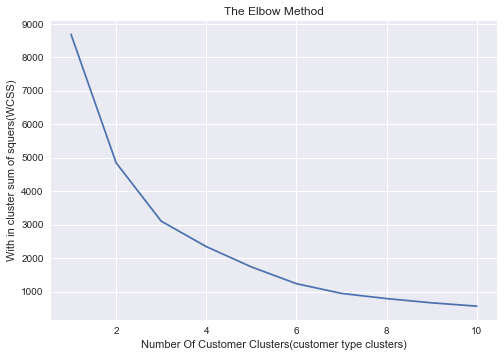

In [48]:
for i in range(1,11): #From 2-10 doing multiple random initializations can make a huge difference to find a better local optima
    kmeans = KMeans(n_clusters = i, init ='k-means++',max_iter=300,n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11) , wcss)
plt.title('The Elbow Method')
plt.xlabel('Number Of Customer Clusters(customer type clusters)')
plt.ylabel('With in cluster sum of squers(WCSS)')
plt.show()

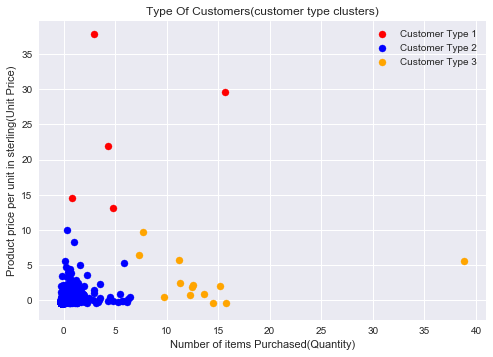

In [53]:
# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = 3, init = 'k-means++')
y_kmeans = kmeans.fit_predict(X)

# Visualising the clusters
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 50, c = 'red', label = 'Customer Type 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 50, c = 'blue',label = 'Customer Type 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 50, c = 'orange',label = 'Customer Type 3')
plt.title('Type Of Customers(customer type clusters)')
plt.xlabel('Number of items Purchased(Quantity)')
plt.ylabel('Product price per unit in sterling(Unit Price)')
plt.legend()
plt.show()

In [55]:
# Applying PCA Algorithm
# We use only 'Quantity','UnitPrice' columns to cluser 
X1 = df_new.iloc[:, [0, 1]].values

In [56]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X1= sc_X.fit_transform(X1)

In [74]:
# SELF Organising Map


import MiniSom 
som = MiniSom(x = 10 , y = 10 , input_len = 2 , sigma = 1.0 , learning_rate = 0.5)
som.random_weights_init(X)
som.train_random(data = X , num_iteration = 100)


som = MiniSom(x = 10 , y = 10 , input_len = 2 , sigma = 1.0 , learning_rate = 0.5)
som.random_weights_init(X)
som.train_random(data = X , num_iteration = 100)



ModuleNotFoundError: No module named 'MiniSom'